In [1]:
import pandas as pd
import numpy as np
import pytraj as pyt
import csv
import ast
import datetime
import matplotlib.pyplot as plt
from modulos.MDS import cMDS, cMDS_proj
from modulos.plotting_functions import density_estimation, plot_mds_or_pca, plot_anotation_labels

/home/joel/anaconda3/envs/mds/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [2]:
df_cdk2 = pd.read_csv("./B_DATOS/TABLA_MTDATA_CDK2_402_crys_LIGS_INFO.csv", index_col = 0,
                     converters={"NameLigs": lambda x: ast.literal_eval(x),
                                "GapPos": lambda x: ast.literal_eval(x),
                                 "Date": lambda x: (datetime.datetime.strptime(x, "%Y-%m-%d")),
                                 "NameLigs": lambda x: ast.literal_eval(x),
                                })
df_cdk2.set_index("PDB_ID", inplace=True)
df_cdk2.head(3)

,Title,Date,Entities,ChainID,Resolution,Identity,Coverage,NumGaps,GapLen,GapPos,NumLigs,NameLigs,Inhib,Inhib_mass
PDB_ID,,,,,,,,,,,,,,
1aq1,human cyclin dependent kinase 2 complexed with...,1997-11-12,1,A,2.0,298.0,92.953020,2.0,"[8, 13]","[[36, 43], [149, 161]]",1.0,['STU'],STU,440.0
1b38,human cyclin-dependent kinase 2,1998-12-23,1,A,2.0,298.0,97.315436,1.0,[8],"[[36, 43]]",3.0,"['ACE', 'ATP', 'MG']",ATP,398.0
1b39,human cyclin-dependent kinase 2 phosphorylated...,1998-12-23,1,A,2.1,298.0,97.315436,1.0,[8],"[[36, 43]]",3.0,"['ACE', 'ATP', 'MG']",ATP,398.0


#### Estructuras cristalográficas de la CDK2

In [3]:
# Carga de la trayectoria de estructuras cristalograficas
file_pdb_traj_pisani = "../ARCHIVOS/CRISTALES/TRAJ_CRISTALS_PDB/PDB_402_cdk2_PISANI_ALL.pdb"
traj_crystals = pyt.load(file_pdb_traj_pisani)

print(F'Número de frames: {traj_crystals.n_frames}.\nNúmero de átomos: {traj_crystals.n_atoms}.')

Número de frames: 402.
Número de átomos: 4848.


In [4]:
# Función para etiquetar cada estructura
from modulos.label_cdk2_confs import label_cdk2_conformations
labels_cdk2 = label_cdk2_conformations(traj_crystals)
df_cdk2["Labels_conf"] = labels_cdk2
df_cdk2.head(5)

,Title,Date,Entities,ChainID,Resolution,Identity,Coverage,NumGaps,GapLen,GapPos,NumLigs,NameLigs,Inhib,Inhib_mass,Labels_conf
PDB_ID,,,,,,,,,,,,,,,
1aq1,human cyclin dependent kinase 2 complexed with...,1997-11-12,1,A,2.00,298.0,92.953020,2.0,"[8, 13]","[[36, 43], [149, 161]]",1.0,['STU'],STU,440.0,inact_b
1b38,human cyclin-dependent kinase 2,1998-12-23,1,A,2.00,298.0,97.315436,1.0,[8],"[[36, 43]]",3.0,"['ACE', 'ATP', 'MG']",ATP,398.0,inact_a
1b39,human cyclin-dependent kinase 2 phosphorylated...,1998-12-23,1,A,2.10,298.0,97.315436,1.0,[8],"[[36, 43]]",3.0,"['ACE', 'ATP', 'MG']",ATP,398.0,inact_a
1buh,crystal structure of the human cdk2 kinase com...,1998-09-09,2,A,2.60,298.0,96.308725,2.0,"[7, 4]","[[40, 46], [295, 298]]",0.0,[],NaN,NaN,inact_a
1ckp,human cyclin dependent kinase 2 complexed with...,1999-01-13,1,A,2.05,298.0,93.624161,2.0,"[8, 11]","[[36, 43], [153, 163]]",2.0,"['EDO', 'PVB']",PVB,214.0,inact_a


In [5]:
from modulos.subsecuencias_cdk2 import *
pisiani_residues = get_pisani_residues(sep=",") # subsecuencia de la estructura secuendaria
pocket_residues = get_pocket_residues(sep=",")

In [6]:
# Filtrado de las estructuras
# Primera condición
res_25_A_o_menos = df_cdk2.Resolution <= 2.5

# Segunda condición
from modulos.find_gaps import is_a_gap
no_gaps_en_seq = df_cdk2.GapPos.apply( lambda x: is_a_gap(x, get_pisani_residues(x="list")) )

# Tercera condición: ¿Cuántas y cuáles de las estructuras se publicaron como máximo hasta 2015?
fecha_2015_o_menos = df_cdk2.Date.apply(lambda x:  x.year  <= 2015)

# Obtenemos los índices resultantes
frames_pisani = np.array((res_25_A_o_menos) & (no_gaps_en_seq) & (fecha_2015_o_menos))

In [7]:
# RMSD por pares de las 402 estructuras
pair_rmsd_402_struc = pyt.pairwise_rmsd( traj = traj_crystals, mask= F"(:{pisiani_residues})&(@CA)", metric="rmsd")

# Subset de RMSD por pares usando sólo sus 255 estructuras
pair_rmsd_pisani = pair_rmsd_402_struc[:, frames_pisani][frames_pisani, :]

In [8]:
# MDS, usamos la función que previamente habíamos definido en moduloes.cMDS
mds_pisani = cMDS(pair_rmsd_pisani)

mds_total_402 = cMDS(pair_rmsd_402_struc)

In [9]:
df_cdk2.index.get_loc("4fkw")

342

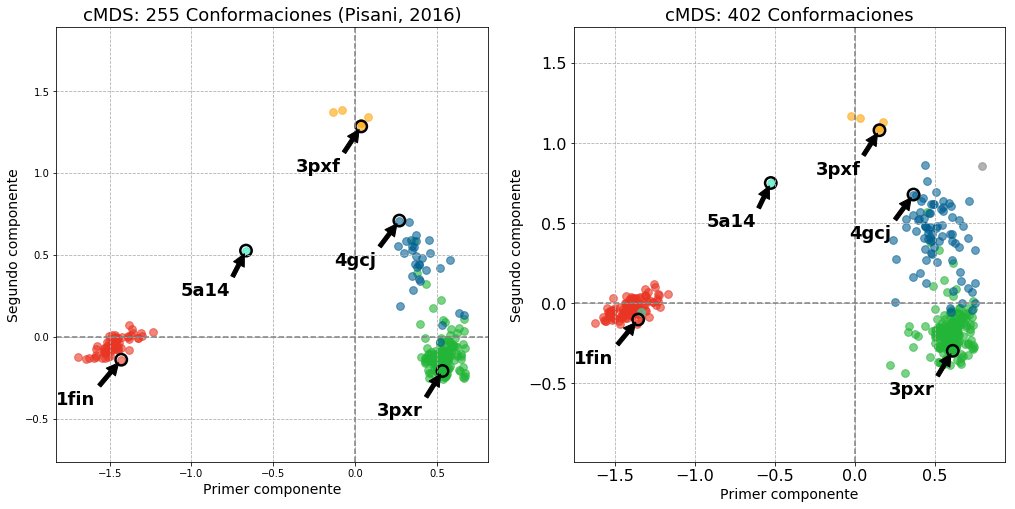

In [10]:
# Estructuras de  referencia que queremos mostrar en la gráfica
ref_structs_dict = {"1fin": "red", "5a14": "cyan", "3pxr": "green", "4gcj": "blue", "3pxf": "orange"}
# Etiquetas según el PDB ID de cada estructura
traj_labels_pisani = df_cdk2.index[frames_pisani]
# Se genera la gráfica
fig = plt.figure(figsize=(17, 8))
plt.subplot(1, 2, 1)
plot_mds_or_pca(mds = mds_pisani[0], labels = df_cdk2.Labels_conf[frames_pisani],
                             title = "cMDS: 255 Conformaciones (Pisani, 2016)")
plot_anotation_labels(df_cdk2.index[frames_pisani],  ref_structs_dict.keys(), 
                      mds_pisani[0][0], mds_pisani[0][1], xytext_delta=[0.4, 0.3], s=130)
 
plt.subplot(1, 2, 2)
plot_mds_or_pca(mds = mds_total_402[0], labels = df_cdk2.Labels_conf,
                             title = "cMDS: 402 Conformaciones")
plot_anotation_labels(df_cdk2.index,  ref_structs_dict.keys(), 
                      mds_total_402[0][0], mds_total_402[0][1], xytext_delta=[0.4, 0.3], s=130)

## Carga y procesamiento de las trayectorias

### Cálculo de las matrices de RMSD (suplementarias)
Para obtener las matrices de RMSD de cada trayectoria frente a las 402 estructuras cristalográficas:
- **1) Se cargan los CA de cada trayectoria.**
    - Se cargan los archivos *prmtop* y *nc*.
- **2) Se une cada trayectoria de forma independiente a la _trayectoria de 402 cristales_. Para ello la siguiente función realiza lo siguiente:**
    - Se copia la trayectoria de 
    - En *pytraj* las coordenadas de la trayectoria de DM se concatenan al *objeto*

In [11]:
def get_sup_rmsd_pairwise(temp_traj, traj_out_of_sample, ref = 0, mask = F"(:{pisiani_residues})&(@CA)"):
    num_initial_frames = temp_traj.n_frames
    temp_traj.append_xyz(traj_out_of_sample.xyz)
    
    pyt.align(temp_traj, F"(:{pisiani_residues})&(@CA)", ref = ref)
    
    mtx_rmsd_sup = np.empty((num_initial_frames, traj_out_of_sample.n_frames))
    for i in range(num_initial_frames):
        rmsd = pyt.rmsd(traj= temp_traj, mask=mask, ref = i, 
                        nofit=True, frame_indices = range(num_initial_frames, temp_traj.n_frames))
        mtx_rmsd_sup[i] = rmsd
    return mtx_rmsd_sup.T

In [12]:
def generate_Dsup(traj_references, sup_top_file, sup_traj_file, mask ="@CA"):
    '''
    '''
    temp_traj = traj_references.copy().strip("!" + mask)
    sup_traj = pyt.load( top = sup_top_file, filename = sup_traj_file, mask = mask)
    D_sup = get_sup_rmsd_pairwise(temp_traj, sup_traj) # Cálcular la matriz D
    return D_sup

In [13]:
a = traj_crystals.copy()
a.strip("!@CA")

pytraj.Trajectory, 402 frames: 
Size: 0.002678 (GB)
<Topology: 298 atoms, 298 residues, 298 mols, non-PBC>
           

### Se generan las matrices suplementarias para cada trayectoria

In [14]:
path_dinamicas = "../ARCHIVOS/DINAMICA/"
path_to_save_D_matx = "./B_DATOS/distance_matrix"

#### Trayectorias de dinámica molecular CDK2
- Estructura inicial **1fin**, método: **_Dinámica Molecular con SA_**

In [15]:
# Trayectoria de dinámica molecular
# 1fin SA_DM
if True:
    file_sa_1fin_r1 = path_dinamicas + "1fin/sa_dm/rep_1/"
    D_sup_1fin_SA_r1 = generate_Dsup(traj_crystals, sup_top_file=file_sa_1fin_r1 + "sa_dm_1fin.prmtop",
                    sup_traj_file= file_sa_1fin_r1 + "4_prod/" + "sa_dm_1fin_prod.nc", mask ="@CA")
    np.save( F"{path_to_save_D_matx}/D_sup_1fin_SA_r1_rmsd.npy", D_sup_1fin_SA_r1 ) 
else: # Leer desde archivo
    D_sup_1fin_SA_r1 = np.load(F"{path_to_save_D_matx}/D_sup_1fin_SA_r1_rmsd.npy")

- Estructura inicial **1fin**, método: **_Solventes mixtos + SA (etanol)_**

In [172]:
# Trayectoria de dinámica molecular
# 1fin SA_DM
if False:
    file_mxs_1fin_r1 = path_dinamicas + "1fin/mxs_sa/rep_1/"
    D_sup_1fin_MXS_r1 = generate_Dsup(traj_crystals, sup_top_file= file_mxs_1fin_r1 + "mxs_1fin.prmtop",
                    sup_traj_file= file_mxs_1fin_r1 + "4_prod/" + "mxs_1fin_prod.nc", mask ="@CA")
    np.save( F"{path_to_save_D_matx}/D_sup_1fin_MXS_r1_rmsd.npy", D_sup_1fin_MXS_r1 ) 
else:
    D_sup_1fin_MXS_r1 = np.load(F"{path_to_save_D_matx}/D_sup_1fin_MXS_r1_rmsd.npy")

#### Conformación 4fku

- Estructura inicial **4fku**, método: **_Dinámica Molecular + SA_**

In [173]:
if False:
    file_sa_4fku_r1 = path_dinamicas + "4fku/sa_dm/rep_4/"
    D_sup_4fku_SA_r1 = generate_Dsup(traj_crystals, sup_top_file= file_sa_4fku_r1 + "cdk2.prmtop", 
                        sup_traj_file= file_sa_4fku_r1 + "3_prod/" + "cdk2_prod.nc", mask ="@CA")
    np.save( F"{path_to_save_D_matx}/D_sup_4fku_SA_r1_rmsd.npy", D_sup_4fku_SA_r1 ) 
else:
    D_sup_4fku_SA_r1 = np.load(F"{path_to_save_D_matx}/D_sup_4fku_SA_r1_rmsd.npy")

- Estructura inicial **4fku**, método: **_Solventes mixtos + SA (etanol)_**

In [174]:
if False:
    file_mxs_4fku_r1 = path_dinamicas + "4fku/mxs_sa/rep_mxSA_1/"
    D_sup_4fku_MXS_r1 = generate_Dsup(traj_crystals, sup_top_file= file_mxs_4fku_r1 + "mxs_cdk2.prmtop", 
                            sup_traj_file= file_mxs_4fku_r1 + "4_prod/" + "mxs_cdk2_prod.nc", mask ="@CA")
    np.save( F"{path_to_save_D_matx}/D_sup_4fku_MXS_r1_rmsd.npy", D_sup_4fku_MXS_r1 ) 
else:
    D_sup_4fku_MXS_r1 = np.load(F"{path_to_save_D_matx}/D_sup_4fku_MXS_r1_rmsd.npy")

- Estructura inicial **4fku**, método: **_Con ligando_**

In [175]:
if False:
    file_lig_4fku_r1 = path_dinamicas + "4fku/sa_lig_CS262/rep_4/"
    D_sup_4fku_LIG_r1 = generate_Dsup(traj_crystals, sup_top_file= file_lig_4fku_r1 + "cdk2_LIG.prmtop", 
                            sup_traj_file= file_lig_4fku_r1 + "4_prod/" + "cdk2_LIG_prod.nc", mask ="@CA")
    np.save( F"{path_to_save_D_matx}/D_sup_4fku_LIG_r1_rmsd.npy", D_sup_4fku_LIG_r1 ) 
else:
    D_sup_4fku_LIG_r1 = np.load(F"{path_to_save_D_matx}/D_sup_4fku_LIG_r1_rmsd.npy")

- Estructura inicial **4fku**, método: **_Dinámica molecular acelerada_**  
Dado que el archivo original pesa 5 GB, previamente extraje con cpptraj la trayectoria (no he probado cuanta RAM y tiempo de procesamiento le tomaría a pytraj).

In [176]:
if False:
    file_aMD_4fku_r1 = path_dinamicas + "4fku/mix_solv/rep_1/5_aMD/"
    D_sup_4fku_aMD_r1 = generate_Dsup(traj_crystals, sup_top_file= file_aMD_4fku_r1 + "strip.mxs_cdk2.prmtop", 
                            sup_traj_file= file_aMD_4fku_r1  + "mxs_cdk2_aMD_CA.nc", mask = None)
    np.save( F"{path_to_save_D_matx}/D_sup_4fku_aMD_r1_rmsd.npy", D_sup_4fku_aMD_r1) 
else:
    D_sup_4fku_aMD_r1 = np.load(F"{path_to_save_D_matx}/D_sup_4fku_aMD_r1_rmsd.npy")

## Proyección de nuevos puntos al cMDS
#### *Output sample projection*

In [177]:
from modulos.MDS import cMDS_proj

In [178]:
mds_1fin_SA_r1 = cMDS_proj(cMDS_obj = mds_total_402, sup_point = D_sup_1fin_SA_r1)

In [179]:
mds_1fin_MXS_r1 = cMDS_proj(cMDS_obj = mds_total_402, sup_point = D_sup_1fin_MXS_r1)

In [180]:
mds_4fku_MXS_r1 = cMDS_proj(cMDS_obj = mds_total_402, sup_point = D_sup_4fku_MXS_r1)

In [181]:
mds_4fku_SA_r1 = cMDS_proj(cMDS_obj = mds_total_402, sup_point = D_sup_4fku_SA_r1)

In [182]:
mds_4fku_LIG_r1 = cMDS_proj(cMDS_obj = mds_total_402, sup_point = D_sup_4fku_LIG_r1)

In [183]:
mds_4fku_aMD_r1 = cMDS_proj(cMDS_obj = mds_total_402, sup_point = D_sup_4fku_aMD_r1)

#### Se procesan los puntos para crear gráficas de contorno

In [191]:
points_1fin_MXS_r1 = density_estimation(mds_1fin_MXS_r1[:, 0], mds_1fin_MXS_r1[:, 1])

points_1fin_SA_r1 = density_estimation(mds_1fin_SA_r1[:, 0], mds_1fin_SA_r1[:, 1])

points_4fku_SA_r1 = density_estimation(mds_4fku_SA_r1[:, 0], mds_4fku_SA_r1[:, 1])

points_4fku_MXS_r1 = density_estimation(mds_4fku_MXS_r1[:, 0], mds_4fku_MXS_r1[:, 1])

points_4fku_LIG_r1 = density_estimation(mds_4fku_LIG_r1[:, 0], mds_4fku_LIG_r1[:, 1])

### Gráficas de proyección de puntos

In [439]:
from modulos.label_cdk2_confs import label_cdk2_conformations
import matplotlib.cm as cm

In [405]:
# Función para etiquetar las conformaciones
def generate_traj_labels(top_file, traj_file):
    traj = pyt.load(top = top_file, filename = traj_file)
    traj_labels = label_cdk2_conformations(traj, min_num_res_helix=8)
    return traj_labels

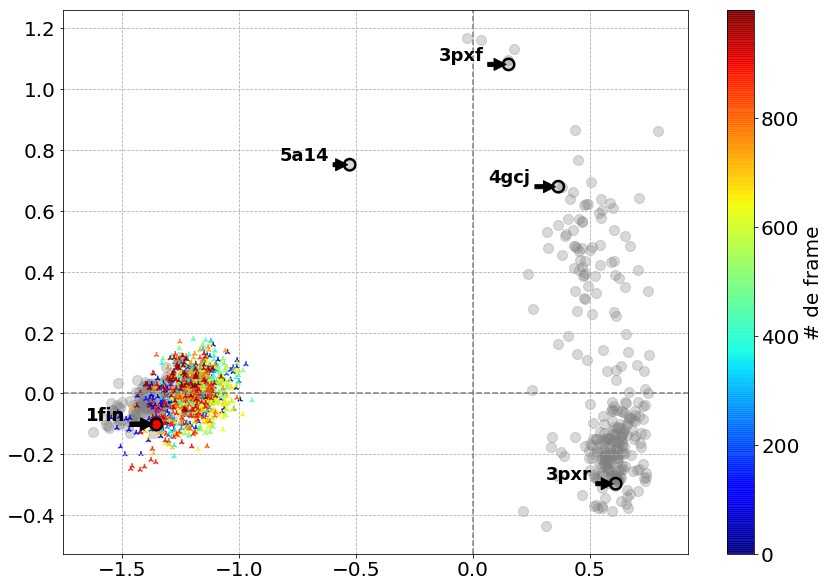

In [532]:
fig = plt.figure(figsize=(14, 10))
plot_mds_or_pca(mds = mds_total_402[0],
                colors_list= ["gray"], general_font_size= 20,
                xlabel="", ylabel="", equal_axis= False,
                title = "",  point_size=100, alpha = 0.3)

points_1fin_SA_r1_non_sorted = density_estimation(mds_1fin_SA_r1[:, 0], mds_1fin_SA_r1[:, 1], sort_points=False)
x, y, z = points_1fin_SA_r1_non_sorted
plt.scatter(x = x, y = y, alpha = 0.9, marker='2', c = range(len(x)), cmap="jet")
cbar = plt.colorbar()
cbar.set_label('# de frame')

plot_anotation_labels(df_cdk2.index, ref_structs_dict.keys(), 
                      mds_total_402[0][0], mds_total_402[0][1], xytext_delta=[0.3, 0.0], s=130)
plot_anotation_labels(df_cdk2.index, ["1fin"],
                      mds_total_402[0][0], mds_total_402[0][1], xytext_delta=[0.3, 0.0], s=130, c="red")

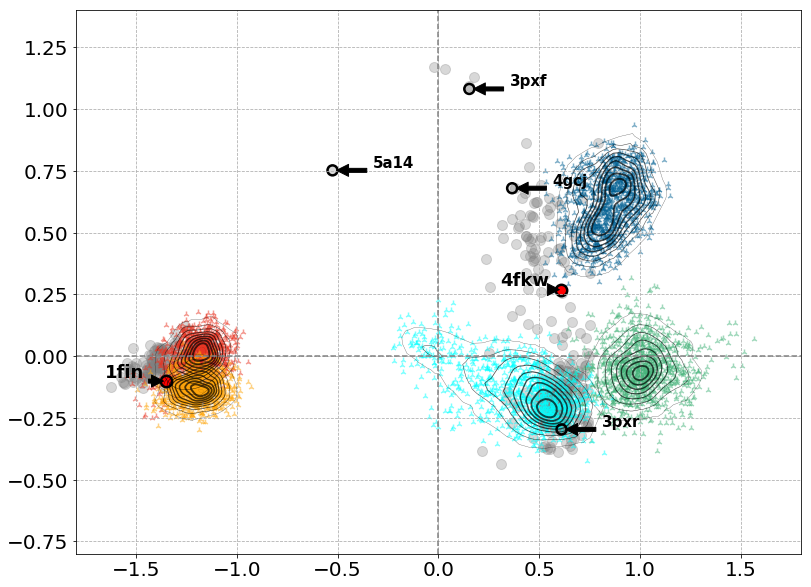

In [528]:
fig = plt.figure(figsize=(13, 10))
plot_mds_or_pca(mds = mds_total_402[0],
                colors_list= ["gray"], general_font_size= 20,
                xlabel="", ylabel="", equal_axis= False,
                title = "",  point_size=100, alpha = 0.3, xy_lims=[-1.8, 1.8, -0.8, 1.4])
# plot de las proyecciones
colores = ['#E93523',  '#FEA50A',   '#45B37A', '#036193', "aqua"] # rojo, amarillo, verde, azul, cyan
lista_trayectorias = [points_1fin_SA_r1, points_1fin_MXS_r1, 
                     points_4fku_SA_r1, points_4fku_MXS_r1, points_4fku_LIG_r1]
intervalos = 10
for traj, color in zip(lista_trayectorias, colores):
    x, y, z = traj
    plt.scatter(x= x, y = y, c = color, alpha = 0.5, marker='2')
    plt.tricontour(x, y, z, intervalos, colors= "black", linewidths=np.linspace(0.1, 2, intervalos), alpha=0.7)

plot_anotation_labels(df_cdk2.index, ["5a14", "3pxf", "4gcj", "3pxr"], 
                      mds_total_402[0][0], mds_total_402[0][1], fontsize = 15, xytext_delta=[-0.2, 0.0], s=100)
plot_anotation_labels(df_cdk2.index, ["4fkw", "1fin"],
                      mds_total_402[0][0], mds_total_402[0][1], xytext_delta=[0.3, 0.0], s=130, c="red")

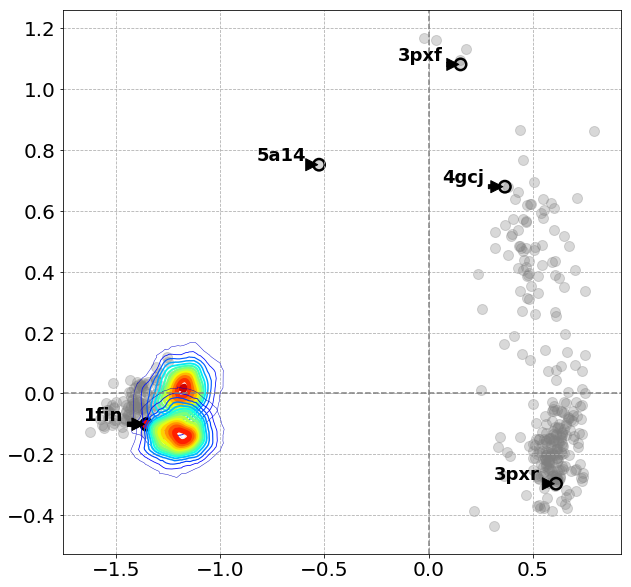

In [476]:
fig = plt.figure(figsize=(10, 10))
plot_mds_or_pca(mds = mds_total_402[0],
                colors_list= ["gray"], general_font_size= 20,
                xlabel="", ylabel="", equal_axis= False,
                title = "",  point_size=100, alpha = 0.3)
intervalos = 15
x, y, z = points_1fin_SA_r1
plt.tricontour(x, y, z, intervalos, linewidths=np.linspace(0.1, 5, intervalos), cmap="jet")

x, y, z = points_1fin_MXS_r1
plt.tricontour(x, y, z, intervalos, linewidths=np.linspace(0.1, 5, intervalos), cmap="jet")

plot_anotation_labels(df_cdk2.index, ref_structs_dict.keys(), 
                      mds_total_402[0][0], mds_total_402[0][1], xytext_delta=[0.3, 0.0], s=130)
plot_anotation_labels(df_cdk2.index, ["1fin"],
                      mds_total_402[0][0], mds_total_402[0][1], xytext_delta=[0.3, 0.0], s=130, c="red")

#### Etiquetado de las cinco trayectorias
**Trayectorias 1fin**

In [471]:
file_sa_1fin_r1 = path_dinamicas + "1fin/sa_dm/rep_1/"
labels_sa_1fin_r1 = generate_traj_labels(top_file= file_sa_1fin_r1 + "sa_dm_1fin.prmtop",
                    traj_file= file_sa_1fin_r1 + "4_prod/" + "sa_dm_1fin_prod.nc")

In [472]:
file_mxs_1fin_r1 = path_dinamicas + "1fin/mxs_sa/rep_1/"
labels_mxs_1fin_r1 = generate_traj_labels(top_file= file_mxs_1fin_r1 + "mxs_1fin.prmtop",
                    traj_file= file_mxs_1fin_r1 + "4_prod/" + "mxs_1fin_prod.nc")

**Trayectorias 4fkw**

In [493]:
file_sa_4fku_r1 = path_dinamicas + "4fku/sa_dm/rep_4/"
labels_sa_4fku_r1 = generate_traj_labels(top_file=  file_sa_4fku_r1 + "cdk2.prmtop", 
                        traj_file= file_sa_4fku_r1 + "3_prod/" + "cdk2_prod.nc")

In [474]:
file_mxs_4fku_r1 = path_dinamicas + "4fku/mxs_sa/rep_mxSA_1/"
labels_mxs_4fku_r1 = generate_traj_labels(top_file=  file_mxs_4fku_r1 + "mxs_cdk2.prmtop", 
                            traj_file = file_mxs_4fku_r1 + "4_prod/" + "mxs_cdk2_prod.nc")

In [475]:
file_lig_4fku_r1 = path_dinamicas + "4fku/sa_lig_CS262/rep_4/"
labels_lig_4fku_r1 = generate_traj_labels(top_file=  file_lig_4fku_r1 + "cdk2_LIG.prmtop", 
                            traj_file = file_lig_4fku_r1 + "4_prod/" + "cdk2_LIG_prod.nc")

#### Conteo de etiquetas

In [494]:
labels_trajs = [labels_sa_1fin_r1, labels_mxs_1fin_r1, labels_sa_4fku_r1, labels_mxs_4fku_r1, labels_lig_4fku_r1]
for traj in labels_trajs:
    print(np.unique(traj, return_counts = True))

(array(['active'], dtype='<U6'), array([1000]))
(array(['active'], dtype='<U6'), array([1000]))
(array(['inact_a', 'inact_b', 'inact_ope'], dtype='<U9'), array([864, 134,   2]))
(array(['inact_b', 'inact_ope'], dtype='<U9'), array([999,   1]))
(array(['inact_a', 'inact_b', 'inact_ope'], dtype='<U9'), array([851, 147,   2]))


#### Plot de las trayectorias etiquetadas

In [ ]:
dic_colors = {"active": "red", "dfg-out": "cyan", "inact_a": "green", "inact_b": "blue", "inact_ope": "orange"}

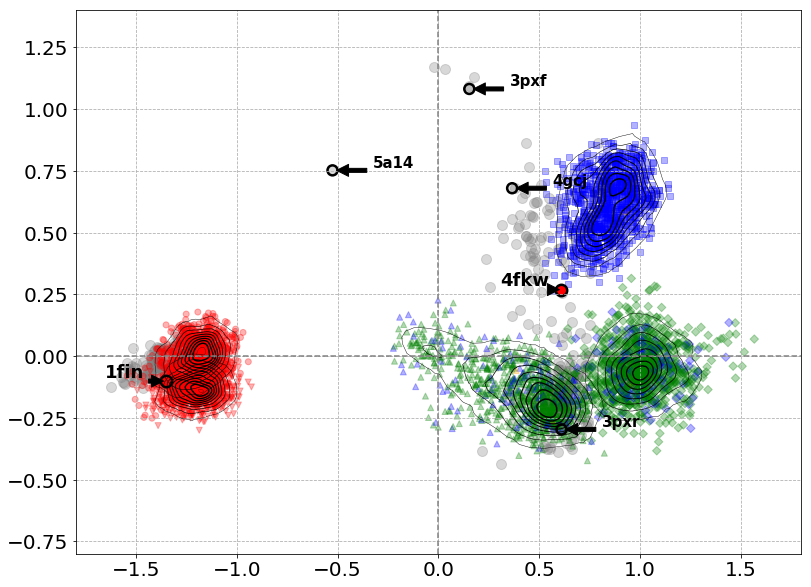

In [505]:
fig = plt.figure(figsize=(13, 10))
plot_mds_or_pca(mds = mds_total_402[0],
                colors_list= ["gray"], general_font_size= 20,
                xlabel="", ylabel="", equal_axis= False,
                title = "",  point_size=100, alpha = 0.3, xy_lims=[-1.8, 1.8, -0.8, 1.4])
intervalos = 10
marcadores = ['o', 'v', 'D', 's', '^']
lista_trayectorias = [points_1fin_SA_r1, points_1fin_MXS_r1, 
                     points_4fku_SA_r1, points_4fku_MXS_r1,  points_4fku_LIG_r1]
for points, labels, mk in zip(lista_trayectorias, labels_trajs, marcadores):
    lab_colors = [dic_colors[i] for i in labels]
    x, y, z = points
    plt.scatter(x= x, y = y, c = lab_colors, alpha = 0.3, marker= mk)
    plt.tricontour(x, y, z, intervalos, linewidths=np.linspace(0.3, 1.5, intervalos), colors="black")

plot_anotation_labels(df_cdk2.index, ["5a14", "3pxf", "4gcj", "3pxr"], 
                      mds_total_402[0][0], mds_total_402[0][1], fontsize = 15, xytext_delta=[-0.2, 0.0], s=100)
plot_anotation_labels(df_cdk2.index, ["4fkw", "1fin"],
                      mds_total_402[0][0], mds_total_402[0][1], xytext_delta=[0.3, 0.0], s=130, c="red")

#### Dinámica molecualr acelerada

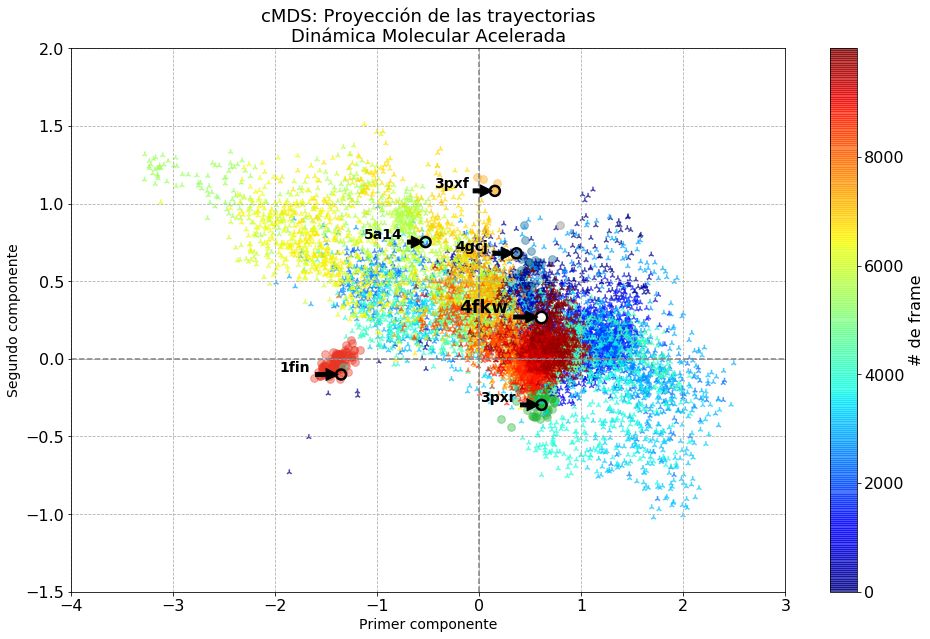

In [526]:
points_4fku_aMD_r1 = density_estimation(mds_4fku_aMD_r1[:, 0], mds_4fku_aMD_r1[:, 1], sort_points=False)

fig = plt.figure(figsize=(16, 10))
plot_mds_or_pca(mds = mds_total_402[0], labels = df_cdk2.Labels_conf, 
                title = "cMDS: Proyección de las trayectorias\nDinámica Molecular Acelerada", 
                alpha = 0.4, xy_lims=[-4.0, 3.0, -1.5, 2.0], equal_axis=False)
# Plot de las conformaciones de la trayectoria
intervalos = 30
x, y, z = points_4fku_aMD_r1
plt.scatter(x = x, y = y, alpha = 0.7, marker='2', c = range(len(x)), cmap="jet")
cbar = plt.colorbar()
cbar.set_label('# de frame')
# Plot de las estructuras de referencia
plot_anotation_labels(df_cdk2.index, ref_structs_dict.keys(), mds_total_402[0][0], mds_total_402[0][1],
                     xytext_delta=[0.6, 0.0], fontsize = 14, s = 100)
plot_anotation_labels(df_cdk2.index, ["4fkw"],
                      mds_total_402[0][0], mds_total_402[0][1], xytext_delta=[0.8, 0.0], s=130, c="white")

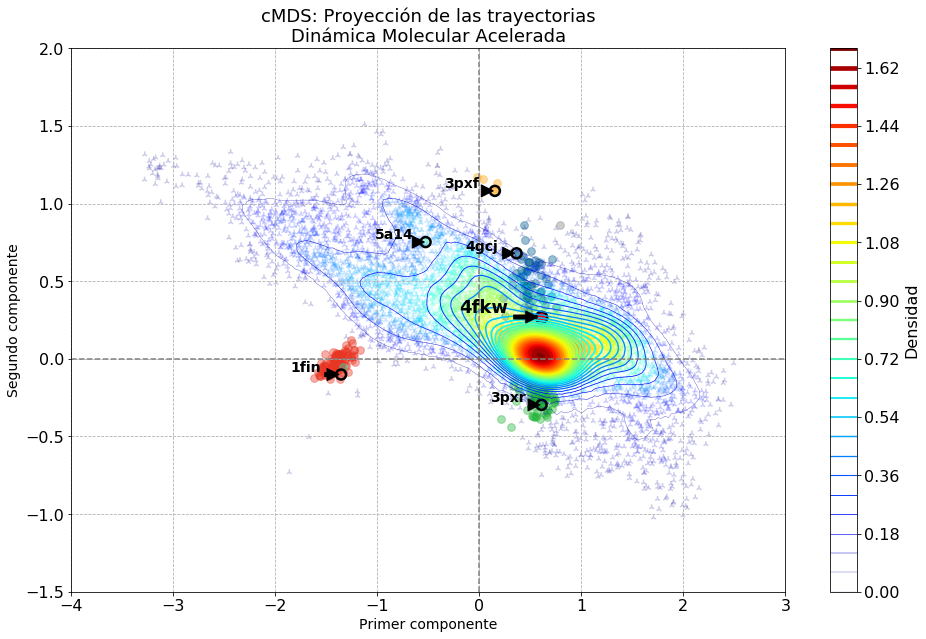

In [521]:
points_4fku_aMD_r1 = density_estimation(mds_4fku_aMD_r1[:, 0], mds_4fku_aMD_r1[:, 1], sort_points=True)
fig = plt.figure(figsize=(16, 10))
plot_mds_or_pca(mds = mds_total_402[0], labels = df_cdk2.Labels_conf, 
                title = "cMDS: Proyección de las trayectorias\nDinámica Molecular Acelerada", 
                alpha = 0.4, xy_lims=[-4.0, 3.0, -1.5, 2.0], equal_axis=False)
# Plot de las conformaciones de la trayectoria
intervalos = 30
x, y, z = points_4fku_aMD_r1
plt.scatter(x = x, y = y, alpha = 0.2, marker='2', c = range(len(x)), cmap="jet")
plt.tricontour(x, y, z, intervalos, linewidths=np.linspace(0.1, 5, intervalos), cmap="jet")
cbar = plt.colorbar()
cbar.set_label('Densidad')
# Plot de las estructuras de referencia
plot_anotation_labels(df_cdk2.index, ref_structs_dict.keys(), mds_total_402[0][0], mds_total_402[0][1],
                     xytext_delta=[0.5, 0.0], fontsize = 14, s = 100)
plot_anotation_labels(df_cdk2.index, ["4fkw"],
                      mds_total_402[0][0], mds_total_402[0][1], xytext_delta=[0.8, 0.0], s=130, c="red")

In [404]:
# Cuantos frames hay entre los puntos centrales x = 0.25, 0.75, y = 0.25, -0.25
x, y, z = points_4fku_aMD_r1
x_index_range = np.where((x >= 0.25) & (x <= 0.75))
total_index_range = np.where((y[x_index_range] <= 0.25) & (y[x_index_range] >= -0.25))
print(F'Un total de {len(total_index_range[0])} conformaciones se encuentran en el sitio de mayor densidad')

Un total de 2583 conformaciones se encuentran en el sitio de mayor densidad


#### Etiquetas a las trayectorias

In [281]:
%%time
file_aMD_4fku_r1 = path_dinamicas + "4fku/mix_solv/rep_1/5_aMD/"
labels_aMD_4fku_r1 = generate_traj_labels(top_file=  file_aMD_4fku_r1 + "protein.mxs_cdk2.prmtop", 
                            traj_file = file_aMD_4fku_r1  + "mxs_cdk2_aMD_protein.nc")

In [544]:
np.unique(labels_aMD_4fku_r1, return_counts=True)

(array(['inact_a', 'inact_b', 'inact_ope'], dtype='<U9'),
 array([5171, 4778,   51]))

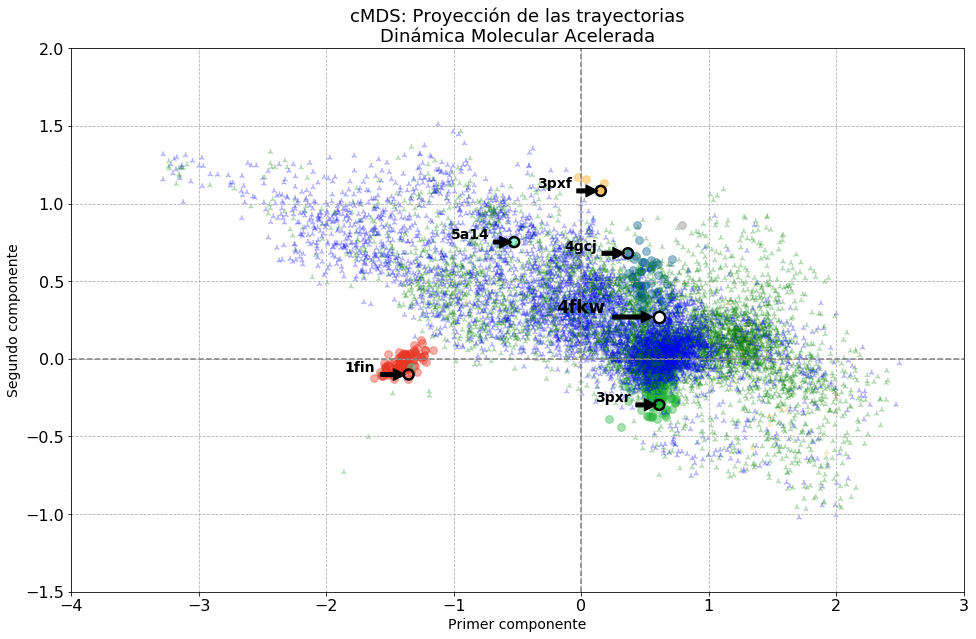

In [602]:
dic_colors = {"active": "red", "dfg-out": "cyan", "inact_a": "green", "inact_b": "blue", "inact_ope": "orange"}
fig = plt.figure(figsize=(16, 10))
plot_mds_or_pca(mds = mds_total_402[0], labels = df_cdk2.Labels_conf, 
                title = "cMDS: Proyección de las trayectorias\nDinámica Molecular Acelerada", 
                alpha = 0.4, xy_lims=[-4.0, 3.0, -1.5, 2.0], equal_axis=False)
# Plot de las conformaciones de la trayectoria
intervalos = 30
colores_aMD_4fku_r1 = [dic_colors[label] for label in labels_aMD_4fku_r1]
x, y, z = points_4fku_aMD_r1
plt.scatter(x = x, y = y, alpha = 0.3, marker='2', c = colores_aMD_4fku_r1)

# Plot de las estructuras de referencia
plot_anotation_labels(df_cdk2.index, ref_structs_dict.keys(), mds_total_402[0][0], mds_total_402[0][1],
                     xytext_delta=[0.5, 0.0], fontsize = 14, s = 100)
plot_anotation_labels(df_cdk2.index, ["4fkw"],
                      mds_total_402[0][0], mds_total_402[0][1], xytext_delta=[0.8, 0.0], s=130, c="white")

In [573]:
x, y, z = points_4fku_aMD_r1
a = np.where(np.array(labels_aMD_4fku_r1) == "inact_ope")[0]
x[a]
np.unique(np.array(colores_aMD_4fku_r1), return_counts=True)

(array(['blue', 'green', 'orange'], dtype='<U6'), array([4778, 5171,   51]))

In [580]:
len(np.where(np.array(labels_aMD_4fku_r1) == "inact_ope")[0])

51

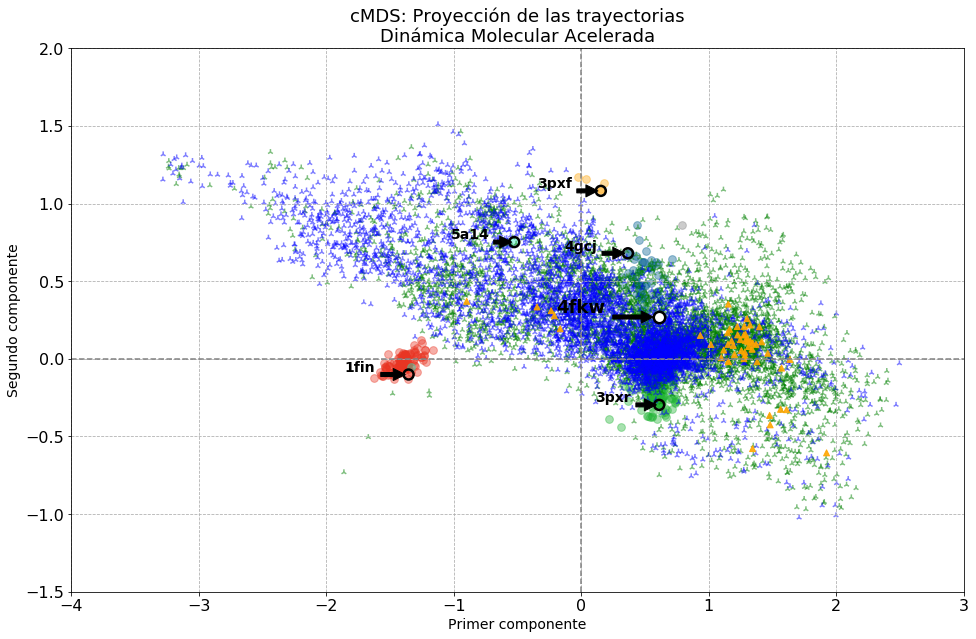

In [606]:
dic_colors = {"active": "red", "dfg-out": "cyan", "inact_a": "green", "inact_b": "blue", "inact_ope": "orange"}
fig = plt.figure(figsize=(16, 10))
plot_mds_or_pca(mds = mds_total_402[0], labels = df_cdk2.Labels_conf, 
                title = "cMDS: Proyección de las trayectorias\nDinámica Molecular Acelerada", 
                alpha = 0.4, xy_lims=[-4.0, 3.0, -1.5, 2.0], equal_axis=False)
# Plot de las conformaciones de la trayectoria
intervalos = 8
index_col = np.where(np.array(labels_aMD_4fku_r1) == "inact_a")[0]
colores_aMD_4fku_r1 = [dic_colors[label] for label in labels_aMD_4fku_r1]
x, y, z = points_4fku_aMD_r1
plt.scatter(x = x[index_col], y = y[index_col], alpha = 0.5, marker='2', c = np.array(colores_aMD_4fku_r1)[index_col])

index_col = np.where(np.array(labels_aMD_4fku_r1) == "inact_b")[0]
colores_aMD_4fku_r1 = [dic_colors[label] for label in labels_aMD_4fku_r1]
x, y, z = points_4fku_aMD_r1
plt.scatter(x = x[index_col], y = y[index_col], alpha = 0.5, marker='2', c = np.array(colores_aMD_4fku_r1)[index_col])

index_col = np.where(np.array(labels_aMD_4fku_r1) == "inact_ope")[0]
colores_aMD_4fku_r1 = [dic_colors[label] for label in labels_aMD_4fku_r1]
x, y, z = points_4fku_aMD_r1
plt.scatter(x = x[index_col], y = y[index_col], alpha = 0.9, marker='^', c = np.array(colores_aMD_4fku_r1)[index_col])

# Plot de las estructuras de referencia
plot_anotation_labels(df_cdk2.index, ref_structs_dict.keys(), mds_total_402[0][0], mds_total_402[0][1],
                     xytext_delta=[0.5, 0.0], fontsize = 14, s = 100)
plot_anotation_labels(df_cdk2.index, ["4fkw"],
                      mds_total_402[0][0], mds_total_402[0][1], xytext_delta=[0.8, 0.0], s=130, c="white")